In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import plotly.express as px

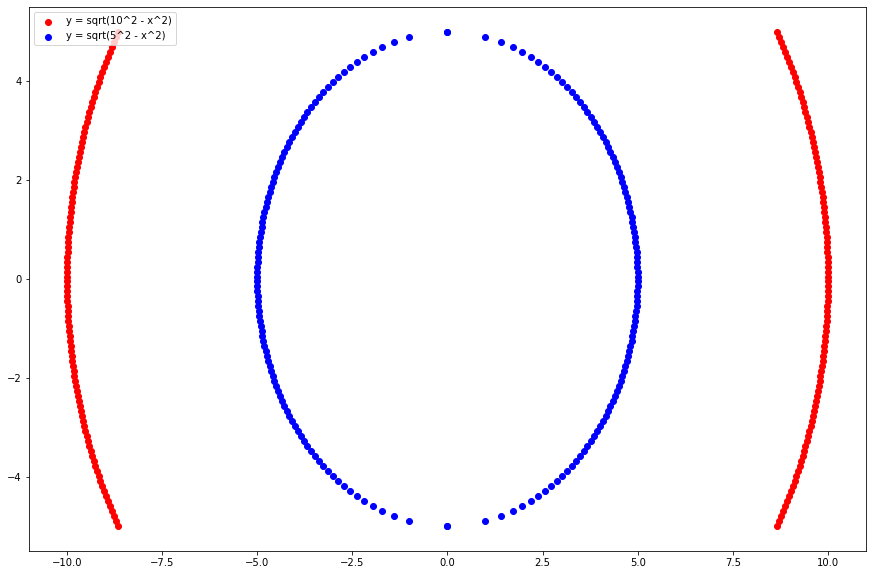

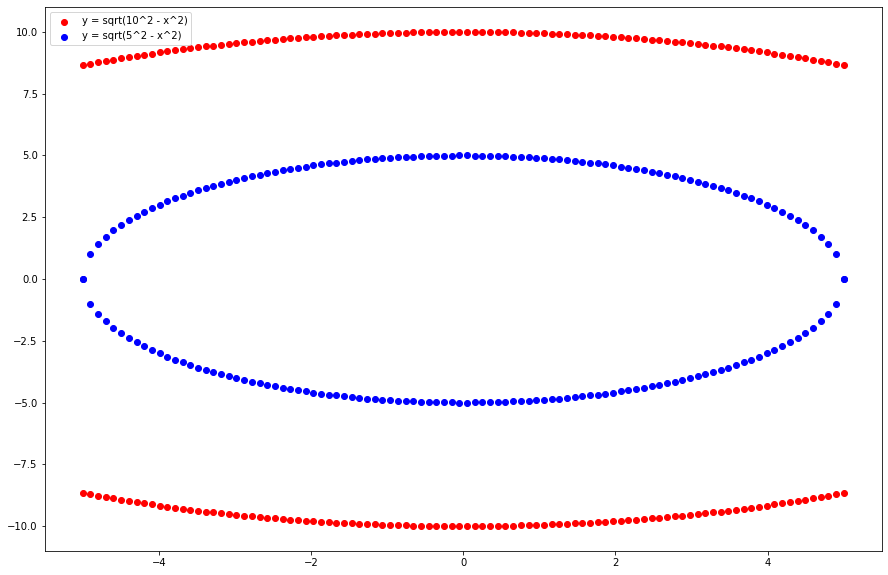

         X1       X2  Y
0  8.660254 -5.00000  0
1  8.717792 -4.89899  0
2  8.773790 -4.79798  0
3  8.828277 -4.69697  0
4  8.881281 -4.59596  0
Accuracy of SVM linear kernel classifier on test data: 0.55
Accuracy of SVM rbf kernel classifier on test data: 1.00


In [75]:
x = np.linspace(-5.0, 5.0, 100) # 100 linearly spaced numbers
y = np.sqrt(10**2 - x**2) 
y = np.hstack([y, -y])  # first set of points
x = np.hstack([x, -x])

x_1 = np.linspace(-5.0, 5.0, 100)
y_1 = np.sqrt(5**2 - x_1**2)
y_1 = np.hstack([y_1, -y_1])    # second set of points
x_1 = np.hstack([x_1, -x_1])

plt.figure(figsize=(15, 10))
plt.scatter(y, x, color='red', label='y = sqrt(10^2 - x^2)')
plt.scatter(y_1, x_1, color='blue', label='y = sqrt(5^2 - x^2)')
plt.legend(loc='upper left')

plt.figure(figsize=(15, 10))
plt.scatter(x, y, color='red', label='y = sqrt(10^2 - x^2)')
plt.scatter(x_1, y_1, color='blue', label='y = sqrt(5^2 - x^2)')
plt.legend(loc='upper left')
plt.show()

df_1 = pd.DataFrame(np.vstack([y, x]).T, columns=['X1', 'X2'])
df_1['Y'] = 0

df_2 = pd.DataFrame(np.vstack([y_1, x_1]).T, columns=['X1', 'X2'])
df_2['Y'] = 1

df = df_1.append(df_2)
print(df.head())

# Independent and dependent features
X = df.iloc[:, :-1]
y = df.Y

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

SVM_classifier_linear = SVC(kernel='linear')
SVM_classifier_linear.fit(X_train, y_train)

linear_y_predict = SVM_classifier_linear.predict(X_test)
linear_accuracy = accuracy_score(y_test, linear_y_predict)
print('Accuracy of SVM linear kernel classifier on test data: {:.2f}'.format(linear_accuracy))

SVM_classifier_rbf = SVC(kernel='rbf')
SVM_classifier_rbf.fit(X_train, y_train)
rbf_y_predict = SVM_classifier_rbf.predict(X_test)
rbf_accuracy = accuracy_score(y_test, rbf_y_predict)
print('Accuracy of SVM rbf kernel classifier on test data: {:.2f}'.format(rbf_accuracy))

#### ***Polynomial kernel***
$$ K(x, y) = (x^{T}y + c)^{d} $$
$x \text{ is } (x_{1} \text{ and } x_{2}) \text{ features}$
$$ \\ $$ 
$y \text{ is } (x_{1} \text{ and } x_{2}) \text{ features}$
$$ \\ $$
$d \text{ is number of wights in problem}$

#### ***Radial basis function (rbf)***
$$ {\displaystyle K(\mathbf {x} ,\mathbf {x'} )=\exp \left(-{\frac {\|\mathbf {x} -\mathbf {x'} \|^{2}}{2\sigma ^{2}}}\right)} $$

In [53]:
# Calculating x^T * y matrix values
df["X1_Squared"] = df.X1**2
df["X2_Squared"] = df.X2**2
df["X1 * X2"] = df.X1*df.X2
print(df.head())

# Independent and dependent features
X = df.iloc[:, :-1]
y = df.Y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
# X_train, y_train

fig = px.scatter_3d(df, x="X1", y="X2", z="X1 * X2", color="X1")
fig.show()

fig = px.scatter_3d(df, x="X1_Squared", y="X2_Squared", z="X1 * X2", color="X1")
fig.show()

         X1       X2  Y  X1_Squared  X2_Squared    X1 * X2
0  8.660254 -5.00000  0   75.000000   25.000000 -43.301270
1  8.717792 -4.89899  0   75.999898   24.000102 -42.708375
2  8.773790 -4.79798  0   76.979390   23.020610 -42.096467
3  8.828277 -4.69697  0   77.938476   22.061524 -41.466150
4  8.881281 -4.59596  0   78.877155   21.122845 -40.818009


In [ ]:
# Support Vector Machine - Optimal Margin Calssifier
import numpy as np
import cvxopt
from utils import *
from sklearn.svm import SVC

def linear_kernel(x, z):
    return np.dot(x, z.T)

def polynomial_kernel(x, z, p=5):
    return (1 + np.dot(x, z.T))**p


def guassian_kernel(x, z, sigma=.1):
    return np.exp(-np.linalg.norm(x - z, axis=1)**2 / (2 * (sigma**2)))

class SVM():
    def __init__(self, kernel=guassian_kernel, C=1):
        self.kernel = kernel
        self.C = C
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        m_samples, n_features = X.shape
        # calculate the kernel matrix
        self.K = np.zeros((m_samples, m_samples))

        for i in range(m_samples):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)
        
        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m_samples, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m_samples) * -1, np.eye(m_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(m_samples), np.ones(m_samples) * self.C)))
        A = cvxopt.matrix(y, (1, m_samples), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])

    def predict(self, X):
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_params(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                 * self.y[sv, np.newaxis]
                 * self.kernel(X[i], self.X[sv])[:, np.newaxis]
                 )
        return np.sign(y_predict + self.b)

    def get_params(self, alphas):
        threshold = 1e-4
        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(self.X[sv].T, alphas[sv]*self.y[sv, np.newaxis])
        self.b = np.mean(self.y[sv, np.newaxis] - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis])
        return sv
        

if __name__ == '__main__':
    # np.random.seed(1)
    X, y = create_dataset(N=50)
    svm = SVM(kernel=guassian_kernel)
    svm.fit(X, y)
    y_pred = svm.predict(X)
    print('Accuracy: %.2f' % (np.mean(y_pred == y) * 100))
    plot_contour(X, y, svm)

    # SVM with SKLearn gussian kernel
    clf = SVC(C=10, kernel='rbf', gamma=10)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    print('Accuracy: %.2f' % (np.mean(y_pred == y) * 100))
    plot_contour(X, y, clf)


In [ ]:
# ToDo
# PART A: implement SVM
# test it on 'd1.csv'
# plot decision boundry including data
# Change C in range [0.1 - 1 - 10 - 100] and analyize output
# consider tolerance=0.001, max_passes=5


In [ ]:
# ToDo
# PART B: Implement Guassian Kernel
# Output shoud be approximatly as '324652.0'
# Consider x_1=[1;2;1], x_2=[0;4;-1], sigma=2.0

In [ ]:
# ToDo:
# Part C: Test algorithm on 'd2.csv'
# Plot decision boundry

In [ ]:
# ToDo:
# Part D: Test algorithm on 'd3.csv'
# Change C and sigma in range [0.001, 0.03, 0.1, 0.3, 1, 3, 10, 100]
# by considering accuracy get best parameters by tuning with validation data ('d3-validation.csv')

In [ ]:
# ToDo:
# Part E:
# plot decision boundry for train data
# plot decision boundry for validation data